In [70]:
from devito import *
import sympy as sp
from filter_generator import filter_generator

SyntaxError: invalid syntax (779138268.py, line 3)

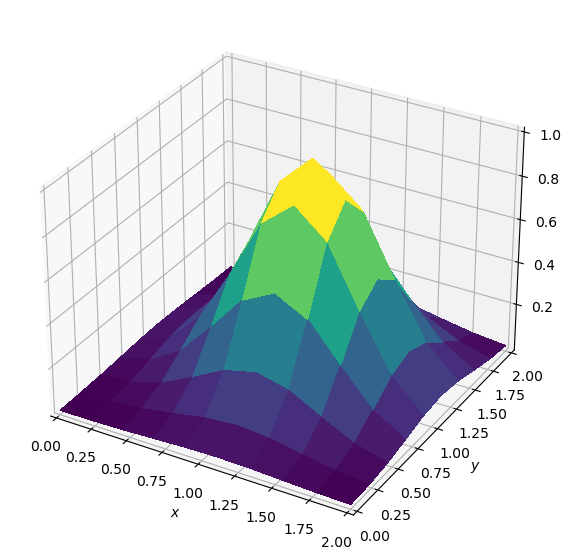

In [43]:
from examples.cfd import  plot_field
import numpy as np

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.01  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(10, 10), extent=(1., 1.))
u = TimeFunction(name='u', grid=grid,time_order = 2, space_order = 2)

# We can now set the initial condition and plot it

init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(u.data[0])


In [44]:
eq = Eq(u.dt + c*u.dx + c*u.dy)
stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)
update

Eq(u(t + dt, x, y), dt*(-Derivative(u(t, x, y), x) - Derivative(u(t, x, y), y) + u(t, x, y)/dt))

In [63]:
from devito import Grid, TimeFunction, Eq, Operator
from sympy import symbols, solve
import numpy as np


# 打印生成的 stencil 表达式
print("Original Stencil Expression:")
print(stencil)
t,x,y = u.dimensions
dt = sp.symbols('dt')
a = u.shift(x, x.spacing)
stencil_fd = stencil.subs({
    dt:0.01,
    u.dx: (u.shift(x,x.spacing) - u.shift(x,-x.spacing))/2/grid.spacing[0],  # x方向偏移1
    u.dy: (u.shift(y, y.spacing) - u.shift(y, -y.spacing))/2/grid.spacing[1]   # y方向偏移1
    
})

# 简化表达式
stencil_fd = stencil_fd.simplify()
coeff_dict = stencil_fd.as_coefficients_dict()
str_coeff = {str(key):value for key,value in coeff_dict.items()}
a = list(str_coeff.keys())[0]
print(a == f'u({t}, {x} - {x.spacing}, {y})',a)
f'u({t}, {x} - {x.spacing}, {y})' in str_coeff

Original Stencil Expression:
dt*(-Derivative(u(t, x, y), x) - Derivative(u(t, x, y), y) + u(t, x, y)/dt)
True u(t, x - h_x, y)


True

In [64]:
g = np.zeros((3,3))
g[0,0]

0.0

In [80]:
from devito import Grid, TimeFunction, Eq, Operator
from sympy import symbols, solve
import numpy as np


# 打印生成的 stencil 表达式
print("Original Stencil Expression:")
print(stencil)
_,x,y = u.dimensions

stencil_fd = stencil.subs({
    
    u.dxl: (u.shift(x, x.spacing) - u.shift(x, -x.spacing))/2/grid.spacing[0],  # x方向偏移1
    u.dyl: (u.shift(y, y.spacing) - u.shift(y, -y.spacing))/2/grid.spacing[1]   # y方向偏移1
})

# 简化表达式
stencil_fd = stencil_fd.simplify()

# 打印替换后的 stencil 表达式
print("\nFinite Difference Stencil Expression:")
print(stencil_fd)

# 构建系数矩阵
coefficients = {}
for term in stencil_fd.args:
    if term.has(u):
        coeff = term.as_coefficients_dict()[u]
        shift_x, shift_y = term.as_coefficients_dict()[u].as_ordered_terms()[0].as_coefficients_dict().keys()
        coefficients[(shift_x, shift_y)] = coeff

# 打印系数矩阵
print("\nCoefficient Matrix:")
for key, value in coefficients.items():
    print(f"Shift {key}: {value}")

# 构建系数矩阵
matrix_size = (grid.shape[0], grid.shape[1])
coefficient_matrix = np.zeros(matrix_size)
for key, value in coefficients.items():
    shift_x = int(key[0].subs({u: 1})) if u in key[0].free_symbols else 0
    shift_y = int(key[1].subs({u: 1})) if u in key[1].free_symbols else 0
    coefficient_matrix[shift_x, shift_y] = value

# 打印系数矩阵
print("\nCoefficient Matrix as Numpy Array:")
print(coefficient_matrix)

Original Stencil Expression:
dt*(-Derivative(u(time, x, y), x) - Derivative(u(time, x, y), y) + u(time, x, y)/dt)

Finite Difference Stencil Expression:
4.5*dt*(u(time, x, y - h_y) - u(time, x, y + h_y) + u(time, x - h_x, y) - u(time, x + h_x, y)) + u(time, x, y)


ValueError: not enough values to unpack (expected 2, got 1)

Operator `Kernel` ran in 0.01 s


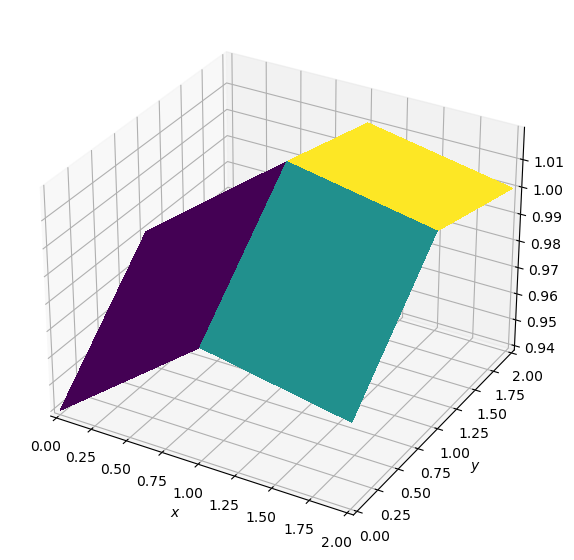

In [27]:
op = Operator(update)
summary = op.apply(dt = dt, time_M =nt-2)
plot_field(u.data[1])

In [7]:
filenames = []
for i in range(100):
    
    plt.imshow(u.data[i], extent=(0, 2, 0, 2), cmap='viridis')
    plt.colorbar(label='u')
    plt.title(f'Wave Equation Solution at t={i*0.01:.2f}')
    filename = f'_tmp{i}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

# 创建gif
with imageio.get_writer('wave_equation.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# 删除临时文件
import os
for filename in filenames:
    os.remove(filename)

print("Animation saved as wave_equation.gif")

/var/folders/cj/7vpbxq116nlcmkbxd8s_svqm0000gn/T/ipykernel_18625/4246058407.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animation saved as wave_equation.gif


In [8]:
from devito import *
from AI4Advection import AI4Advection
from examples.cfd import  plot_field
import numpy as np
import torch
def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.01  # Timestep size (sigma=0.2)
nx = 32
ny = 32
length = 2.
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)
# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor,'./advection_equation_result/AD0')
print(u_tensor.shape)
plot_field(u.data[0])
model = AI4Advection(u = u_tensor, dx = length/nx, dy = length/ny, cx =1, cy = 1, nx = nx, ny = ny,dt = dt)


ModuleNotFoundError: No module named 'AI4Advection'

In [ ]:
model.forward()

In [ ]:
for i in range(1,nt):
    model = AI4Advection(u = u_tensor, dx = length/nx, dy = length/ny, cx =1, cy = 1, nx = nx, ny = ny,dt = dt)
    result = model.forward()
    u_tensor = result
    torch.save(u_tensor,f'./advection_equation_result/AD{i}')

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 定义读取文件夹中所有NumPy数组的函数
def load_numpy_arrays_from_folder(folder_path):
    arrays = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.npy'):
            file_path = os.path.join(folder_path, filename)
            arrays.append(np.load(file_path))
    return arrays

# 定义动画显示函数
def animate_arrays(arrays):
    fig, ax = plt.subplots()
    def update(frame):
        ax.clear()
        ax.imshow(arrays[frame], cmap='viridis')
        ax.set_title(f'Frame {frame + 1}')
    anim = FuncAnimation(fig, update, frames=len(arrays), interval=200)
    return anim

# 加载数组并显示动画
folder_path = './advection_equation_result'  # 替换为实际的文件夹路径
arrays = load_numpy_arrays_from_folder(folder_path)
anim = animate_arrays(arrays)
HTML(anim.to_jshtml())